# Image classification training with image format demo

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Prepare the data](#Prepare-the-data)
3. [Fine-tuning The Image Classification Model](#Fine-tuning-the-Image-classification-model)
  1. [Training parameters](#Training-parameters)
  2. [Training](#Training)
4. [Set Up Hosting For The Model](#Set-up-hosting-for-the-model)
  1. [Create model](#Create-model)
  2. [Create endpoint configuration](#Create-endpoint-configuration)
  3. [Create endpoint](#Create-endpoint)
  4. [Perform inference](#Perform-inference)

## Introduction

Welcome to our end-to-end example of the image classification algorithm training with image format. In this demo, we will use the Amazon sagemaker image classification algorithm in transfer learning mode to fine-tune a pre-trained model (trained on imagenet data) to learn to classify a new dataset. In particular, the pre-trained model will be fine-tuned using [caltech-256 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech256/). 

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.

## Prequisites and Preprocessing

### Permissions and environment variables

Here we set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import boto3
from sagemaker import get_execution_role

role = get_execution_role()

bucket='pilho-sagemaker-ai-workshop' # customize to your bucket
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/image-classification:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/image-classification:latest'}
training_image = containers[boto3.Session().region_name]

CPU times: user 700 ms, sys: 288 ms, total: 988 ms
Wall time: 655 ms


## Fine-tuning the Image classification model

### Prepare the data
The caltech 256 dataset consist of images from 257 categories (the last one being a clutter category) and has 30k images with a minimum of 80 images and a maximum of about 800 images per category. 

The image classification algorithm can take two types of input formats. The first is a [RecordIO format](https://mxnet.incubator.apache.org/tutorials/basic/record_io.html) (content type: application/x-recordio) and the other is a [lst format](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec) (content type: application/x-image). Files for both these formats are available at http://data.dmlc.ml/mxnet/data/caltech-256/. In this example, we will use the lst format for training and use the training/validation split [specified here](http://data.dmlc.ml/mxnet/data/caltech-256/).

In [2]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, '/tmp/'+filename)


# Caltech-256 image files
download('http://www.vision.caltech.edu/Image_Datasets/Caltech256/256_ObjectCategories.tar')
!tar -xf /tmp/256_ObjectCategories.tar -C /tmp

# Tool for creating lst file
download('https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py')

In [3]:
%%bash

# Moving shuffled 60 images of each directory to the training folder
mkdir -p /tmp/caltech_256_train_60
for i in /tmp/256_ObjectCategories/*; do
    c=`basename $i`
    mkdir -p /tmp/caltech_256_train_60/$c
    for j in `ls $i/*.jpg | shuf | head -n 60`; do
        mv $j /tmp/caltech_256_train_60/$c/
    done
done

python /tmp/im2rec.py --list --recursive /tmp/caltech-256-60-train /tmp/caltech_256_train_60/
python /tmp/im2rec.py --list --recursive /tmp/caltech-256-60-val /tmp/256_ObjectCategories/

001.ak47 0
002.american-flag 1
003.backpack 2
004.baseball-bat 3
005.baseball-glove 4
006.basketball-hoop 5
007.bat 6
008.bathtub 7
009.bear 8
010.beer-mug 9
011.billiards 10
012.binoculars 11
013.birdbath 12
014.blimp 13
015.bonsai-101 14
016.boom-box 15
017.bowling-ball 16
018.bowling-pin 17
019.boxing-glove 18
020.brain-101 19
021.breadmaker 20
022.buddha-101 21
023.bulldozer 22
024.butterfly 23
025.cactus 24
026.cake 25
027.calculator 26
028.camel 27
029.cannon 28
030.canoe 29
031.car-tire 30
032.cartman 31
033.cd 32
034.centipede 33
035.cereal-box 34
036.chandelier-101 35
037.chess-board 36
038.chimp 37
039.chopsticks 38
040.cockroach 39
041.coffee-mug 40
042.coffin 41
043.coin 42
044.comet 43
045.computer-keyboard 44
046.computer-monitor 45
047.computer-mouse 46
048.conch 47
049.cormorant 48
050.covered-wagon 49
051.cowboy-hat 50
052.crab-101 51
053.desk-globe 52
054.diamond-ring 53
055.dice 54
056.dog 55
057.dolphin-101 56
058.doorknob 57
059.drinking-straw 58
060.duck 59
061.du

A .lst file is a tab-separated file with three columns that contains a list of image files. The first column specifies the image index, the second column specifies the class label index for the image, and the third column specifies the relative path of the image file. The image index in the first column should be unique across all of the images. Here we make an image list file using the [im2rec](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) tool from MXNet. You can also create the .lst file in your own way. An example of .lst file is shown as follows. 

In [8]:
!head -n 3 /tmp/caltech-256-60-train.lst > example.lst
f = open('example.lst','r')
lst_content = f.read()
print(lst_content)

907	7.000000	008.bathtub/008_0205.jpg
3839	35.000000	036.chandelier-101/036_0046.jpg
20372	194.000000	195.soda-can/195_0041.jpg



Let's see sample images.

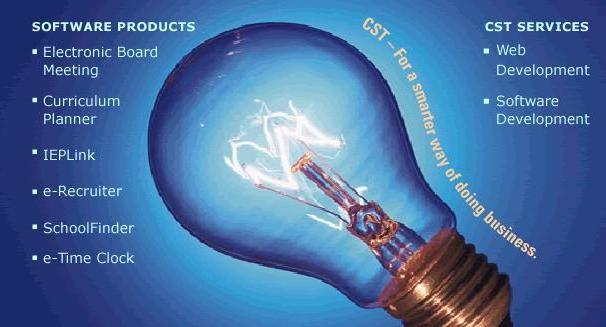

In [11]:
from IPython.display import Image
Image("/tmp/caltech_256_train_60/131.lightbulb/131_0005.jpg")

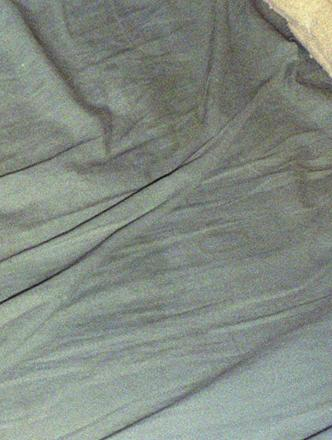

In [16]:
# Clustter category is for unclassified images
Image("/tmp/caltech_256_train_60/257.clutter/257_0425.jpg")

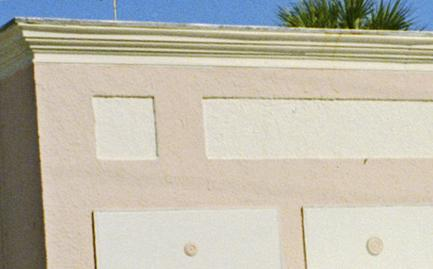

In [15]:
Image("/tmp/caltech_256_train_60/257.clutter/257_0575.jpg")

When you are bringing your own image files to train, please ensure that the .lst file follows the same format as described above. In order to train with the lst format interface, passing the lst file for both training and validation in the appropriate format is mandatory. Once we have the data available in the correct format for training, the next step is to upload the image and .lst file to S3 bucket.

In [5]:
# Four channels: train, validation, train_lst, and validation_lst
s3train = 's3://{}/train/'.format(bucket)
s3validation = 's3://{}/validation/'.format(bucket)
s3train_lst = 's3://{}/train_lst/'.format(bucket)
s3validation_lst = 's3://{}/validation_lst/'.format(bucket)

# upload the image files to train and validation channels
!aws s3 cp /tmp/caltech_256_train_60 $s3train --recursive --quiet
!aws s3 cp /tmp/256_ObjectCategories $s3validation --recursive --quiet

# upload the lst files to train_lst and validation_lst channels
!aws s3 cp /tmp/caltech-256-60-train.lst $s3train_lst --quiet
!aws s3 cp /tmp/caltech-256-60-val.lst $s3validation_lst --quiet

Now we have all the data stored in S3 bucket. The image and lst files will be converted to RecordIO file internelly by the image classification algorithm. But if you want do the conversion, the following cell shows how to do it using the [im2rec](https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py) tool. Note that this is just an example of creating RecordIO files. We are **_not_** using them for training in this notebook. More details on creating RecordIO files can be found in this [tutorial](https://mxnet.incubator.apache.org/how_to/recordio.html?highlight=im2rec).

In [6]:
%%bash
python /tmp/im2rec.py --resize 256 --quality 90 --num-thread 16 /tmp/caltech-256-60-val /tmp/256_ObjectCategories/
python /tmp/im2rec.py --resize 256 --quality 90 --num-thread 16 /tmp/caltech-256-60-train /tmp/caltech_256_train_60/

Creating .rec file from /tmp/caltech-256-60-val.lst in /tmp
time: 0.021434307098388672  count: 0
time: 4.662133693695068  count: 1000
time: 3.4099557399749756  count: 2000
time: 4.078410625457764  count: 3000
time: 5.087332010269165  count: 4000
time: 4.27838397026062  count: 5000
time: 4.205250024795532  count: 6000
time: 3.6777541637420654  count: 7000
time: 6.369385004043579  count: 8000
time: 3.3011977672576904  count: 9000
time: 3.519711971282959  count: 10000
time: 3.417313814163208  count: 11000
time: 3.4601385593414307  count: 12000
time: 3.5263795852661133  count: 13000
time: 2.090500593185425  count: 14000
time: 0.5016591548919678  count: 15000
Creating .rec file from /tmp/caltech-256-60-train.lst in /tmp
time: 0.33762383460998535  count: 0
time: 5.312024116516113  count: 1000
time: 4.209725856781006  count: 2000
time: 3.643160104751587  count: 3000
time: 5.627357721328735  count: 4000
time: 3.2420499324798584  count: 5000
time: 3.389641284942627  count: 6000
time: 3.20974230

After you created the RecordIO files, you can upload them to the train and validation channels for training. To train with RecordIO format, you can follow "[Image-classification-fulltraining.ipynb](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.ipynb)" and "[Image-classification-transfer-learning.ipynb](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-transfer-learning.ipynb)". Again, we will **_not_** use the RecordIO file for the training. The following sections will only show you how to train a model with images and list files.

Before training the model, we need to setup the training parameters. The next section will explain the parameters in detail.

## Fine-tuning the Image Classification Model

### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **Input specification**: These are the training and validation channels that specify the path where training data is present. These are specified in the "InputDataConfig" section. The main parameters that need to be set is the "ContentType" which can be set to "application/x-recordio" or "application/x-image" based on the input data format and the S3Uri which specifies the bucket and the folder where the data is present. 
* **Output specification**: This is specified in the "OutputDataConfig" section. We just need to specify the path where the output can be stored after training
* **Resource config**: This section specifies the type of instance on which to run the training and the number of hosts used for training. If "InstanceCount" is more than 1, then training can be run in a distributed manner. 

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **num_layers**: The number of layers (depth) for the network. We use 18 in this samples but other values such as 50, 152 can be used.
* **image_shape**: The input image dimensions,'num_channels, height, width', for the network. It should be no larger than the actual image size. The number of channels should be same as the actual image.
    * Excerpted from http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf, the first form of data augmentation consists of generating image translations and horizontal reflections. We do this by extracting random 224 × 224 patches (and their horizontal reflections) from the 256×256 images and training our network on these extracted patches. This is the reason why the input images in Figure 2 are 224 × 224 × 3-dimensional. This increases the size of our training set by a factor of 2048, though the resulting training examples are, of course, highly interdependent. Without this scheme, our network suffers from substantial overfitting, which would have forced us to use much smaller networks.
* **num_training_samples**: This is the total number of training samples. It is set to 15240 for caltech dataset with the current split.
* **num_classes**: This is the number of output classes for the new dataset. Imagenet was trained with 1000 output classes but the number of output classes can be changed for fine-tuning. For caltech, we use 257 because it has 256 object categories + 1 clutter class.
* **mini_batch_size**: The number of training samples used for each mini batch. In distributed training, the number of training samples used per batch will be N * mini_batch_size where N is the number of hosts on which training is run.
* **epochs**: Number of training epochs.
* **learning_rate**: Learning rate for training.
* **top_k**: Report the top-k accuracy during training.
* **resize**: Resize the image before using it for training. The images are resized so that the shortest side is of this parameter. If the parameter is not set, then the training data is used as such without resizing.
* **checkpoint_frequency**: Period to store model parameters (in number of epochs).
* **use_pretrained_model**: Set to 1 to use pretrained model for transfer learning.

In [21]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# For this training, we will use 18 layers
num_layers = 18
# we need to specify the input image shape for the training data: "num_channels, height, width"
# See https://news.ycombinator.com/item?id=12509852 for further information on this 224 size 
# which is chosen to allow for the extraction of random patches for translation invariance
image_shape = "3,224,224"
# we also need to specify the number of training samples in the training set
num_training_samples = 15240
# specify the number of output classes
num_classes = 257
# batch size for training
mini_batch_size = 128
# number of epochs
epochs = 6
# learning rate
learning_rate = 0.01
# report top_5 accuracy
top_k = 5
# resize image before training
resize = 256
# period to store model parameters (in number of epochs), in this case, we will save parameters from epoch 2, 4, and 6
checkpoint_frequency = 2
# Since we are using transfer learning, we set use_pretrained_model to 1 so that weights can be 
# initialized with pre-trained weights
use_pretrained_model = 1

### Training
Run the training using Amazon sagemaker CreateTrainingJob API

In [19]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'sagemaker-imageclassification-notebook'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate),
        "top_k": str(top_k),
        "resize": str(resize),
        "checkpoint_frequency": str(checkpoint_frequency),
        "use_pretrained_model": str(use_pretrained_model)    
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/train_lst/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": 's3://{}/validation_lst/'.format(bucket),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        }
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: sagemaker-imageclassification-notebook-2018-06-19-05-49-29

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://pilho-sagemaker-ai-workshop/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 110 ms


In [20]:
%%time
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params)

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress
Training job ended with status: Completed


In [22]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)
print (training_info)

Training job ended with status: Completed
{'TrainingJobName': 'sagemaker-imageclassification-notebook-2018-06-19-05-49-29', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:082256166551:training-job/sagemaker-imageclassification-notebook-2018-06-19-05-49-29', 'ModelArtifacts': {'S3ModelArtifacts': 's3://pilho-sagemaker-ai-workshop/sagemaker-imageclassification-notebook/output/sagemaker-imageclassification-notebook-2018-06-19-05-49-29/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'checkpoint_frequency': '2', 'epochs': '6', 'image_shape': '3,224,224', 'learning_rate': '0.01', 'mini_batch_size': '128', 'num_classes': '257', 'num_layers': '18', 'num_training_samples': '15240', 'resize': '256', 'top_k': '5', 'use_pretrained_model': '1'}, 'AlgorithmSpecification': {'TrainingImage': '811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:latest', 'TrainingInputMode': 'File'}, 'RoleArn': 'arn:aws:iam::082256166551:role/ser

If you see the message,

> `Training job ended with status: Completed`

then that means training sucessfully completed and the output model was stored in the output path specified by `training_params['OutputDataConfig']`.

You can also view information about and the status of a training job using the AWS SageMaker console. Just click on the "Jobs" tab.

## Set Up Hosting For The Model

A trained model does nothing on its own. We now want to use the model to perform inference. For this example, that means predicting the topic mixture representing a given document.

This section involves several steps,

1. [Create model](#CreateModel) - Create model for the training output
1. [Create endpoint configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform inference](#Perform Inference) - Perform inference on some input data using the endpoint.

### Create model

We now create a SageMaker Model from the training output. Using the model we can create an Endpoint Configuration.

In [23]:
%%time
import boto3
from time import gmtime, strftime

sage = boto3.Session().client(service_name='sagemaker') 

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="image-classification-model" + timestamp
print(model_name)
info = sage.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)
hosting_image = containers[boto3.Session().region_name]
primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

image-classification-model-2018-06-19-06-29-30
s3://pilho-sagemaker-ai-workshop/sagemaker-imageclassification-notebook/output/sagemaker-imageclassification-notebook-2018-06-19-05-49-29/output/model.tar.gz
arn:aws:sagemaker:us-east-1:082256166551:model/image-classification-model-2018-06-19-06-29-30
CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 296 ms


### Create endpoint configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [24]:
from time import gmtime, strftime

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_config_name = job_name_prefix + '-epc-' + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.p2.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: sagemaker-imageclassification-notebook-epc--2018-06-19-06-30-18
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:082256166551:endpoint-config/sagemaker-imageclassification-notebook-epc--2018-06-19-06-30-18


### Create endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [25]:
%%time
import time

timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name_prefix + '-ep-' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

Endpoint name: sagemaker-imageclassification-notebook-ep--2018-06-19-06-30-28
EndpointArn = arn:aws:sagemaker:us-east-1:082256166551:endpoint/sagemaker-imageclassification-notebook-ep--2018-06-19-06-30-28
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 285 ms


Finally, now the endpoint can be created. It may take sometime to create the endpoint...

In [26]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))
    
try:
    sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)
finally:
    resp = sagemaker.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Arn: " + resp['EndpointArn'])
    print("Create endpoint ended with status: " + status)

    if status != 'InService':
        message = sagemaker.describe_endpoint(EndpointName=endpoint_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        raise Exception('Endpoint creation did not succeed')

EndpointStatus = Creating
Arn: arn:aws:sagemaker:us-east-1:082256166551:endpoint/sagemaker-imageclassification-notebook-ep--2018-06-19-06-30-28
Create endpoint ended with status: InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

### Perform inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [27]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

#### Download test image

--2018-06-19 06:38:05--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23750 (23K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  23.19K  --.-KB/s    in 0.08s   

2018-06-19 06:38:06 (285 KB/s) - ‘/tmp/test.jpg’ saved [23750/23750]



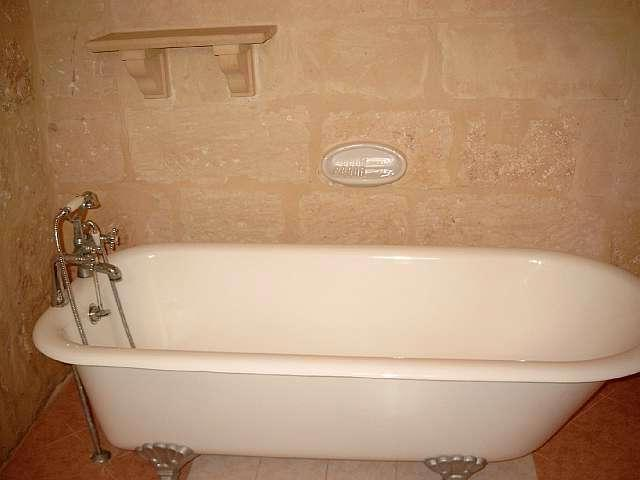

In [28]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [29]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewer-101', 'eyeglasses', 'fern', 'fighter-jet', 'fire-extinguisher', 'fire-hydrant', 'fire-truck', 'fireworks', 'flashlight', 'floppy-disk', 'football-helmet', 'french-horn', 'fried-egg', 'frisbee', 'frog', 'frying-pan', 'galaxy', 'gas-pump', 'giraffe', 'goat', 'golden-gate-bridge', 'goldfish', 'golf-ball', 'goose', 'gorilla', 'grand-piano-101', 'grapes', 'grasshopper', 'guitar-pick', 'hamburger', 'hammock', 'harmonica', 'harp', 'harpsichord', 'hawksbill-101', 'head-phones', 'helicopter-101', 'hibiscus', 'homer-simpson', 'horse', 'horseshoe-crab', 'hot-air-balloon', 'hot-dog', 'hot-tub', 'hourglass', 'house-fly', 'human-skeleton', 'hummingbird', 'ibis-101', 'ice-cream-cone', 'iguana', 'ipod', 'iris', 'jesus-christ', 'joy-stick', 'kangaroo-101', 'kayak', 'ketch-101', 'killer-whale', 'knife', 'ladder', 'laptop-101', 'lathe', 'leopards-101', 'license-plate', 'lightbulb', 'light-house', 'lightning', 'llama-101', 'mailbox', 'mandolin', 'mars', 'mattress', 'megaphone', 'menorah-101', 'microscope', 'microwave', 'minaret', 'minotaur', 'motorbikes-101', 'mountain-bike', 'mushroom', 'mussels', 'necktie', 'octopus', 'ostrich', 'owl', 'palm-pilot', 'palm-tree', 'paperclip', 'paper-shredder', 'pci-card', 'penguin', 'people', 'pez-dispenser', 'photocopier', 'picnic-table', 'playing-card', 'porcupine', 'pram', 'praying-mantis', 'pyramid', 'raccoon', 'radio-telescope', 'rainbow', 'refrigerator', 'revolver-101', 'rifle', 'rotary-phone', 'roulette-wheel', 'saddle', 'saturn', 'school-bus', 'scorpion-101', 'screwdriver', 'segway', 'self-propelled-lawn-mower', 'sextant', 'sheet-music', 'skateboard', 'skunk', 'skyscraper', 'smokestack', 'snail', 'snake', 'sneaker', 'snowmobile', 'soccer-ball', 'socks', 'soda-can', 'spaghetti', 'speed-boat', 'spider', 'spoon', 'stained-glass', 'starfish-101', 'steering-wheel', 'stirrups', 'sunflower-101', 'superman', 'sushi', 'swan', 'swiss-army-knife', 'sword', 'syringe', 'tambourine', 'teapot', 'teddy-bear', 'teepee', 'telephone-box', 'tennis-ball', 'tennis-court', 'tennis-racket', 'theodolite', 'toaster', 'tomato', 'tombstone', 'top-hat', 'touring-bike', 'tower-pisa', 'traffic-light', 'treadmill', 'triceratops', 'tricycle', 'trilobite-101', 'tripod', 't-shirt', 'tuning-fork', 'tweezer', 'umbrella-101', 'unicorn', 'vcr', 'video-projector', 'washing-machine', 'watch-101', 'waterfall', 'watermelon', 'welding-mask', 'wheelbarrow', 'windmill', 'wine-bottle', 'xylophone', 'yarmulke', 'yo-yo', 'zebra', 'airplanes-101', 'car-side-101', 'faces-easy-101', 'greyhound', 'tennis-shoes', 'toad', 'clutter']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - bathtub, probability - 0.9989598989486694


In [32]:
print(result, index, result[index])

[1.8167459359119675e-07, 4.0564689385291786e-08, 4.907876327564509e-09, 8.400127171626082e-08, 2.3297330642435554e-07, 3.293115113933709e-08, 3.0241462667390806e-08, 0.9989598989486694, 4.122069299228315e-07, 1.6723851103961351e-07, 4.335148844347714e-07, 1.470605237585687e-08, 4.919835419059382e-07, 3.78899528641341e-07, 1.7273573860165925e-07, 7.309789396003907e-08, 1.0746944099082612e-06, 6.692810984532116e-06, 1.4750304444532958e-07, 7.721928341197781e-08, 8.257419722212944e-06, 6.605966884620784e-10, 2.259645725644077e-06, 2.285695188675163e-08, 1.4444604801155947e-07, 1.1509112027852098e-06, 2.6346165782342723e-07, 1.319285161116568e-07, 9.397975730962571e-08, 1.659633284134543e-07, 2.3098972690149822e-07, 6.4411875833059185e-09, 1.4453493690780306e-07, 1.4169221174142876e-07, 4.1403747985668815e-08, 2.381261943185109e-08, 2.3651104129385203e-05, 2.95755402390796e-08, 1.5443973211404227e-08, 4.0111584098667663e-07, 4.780331892106915e-06, 8.013061597011983e-05, 3.2564028629167296e

#### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released. Uncomment and run the following cell to delete the endpoint and model

In [33]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'e433243d-b2e2-45cd-b320-9356f1d6b7dc',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 19 Jun 2018 06:40:42 GMT',
   'x-amzn-requestid': 'e433243d-b2e2-45cd-b320-9356f1d6b7dc',
   'content-length': '0',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}